In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lstm
import warnings 

import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer

from lightning.pytorch.tuner import Tuner

import tensorflow as tf
# import tensorboard as tb


warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')
warnings.filterwarnings('ignore', message='X does not have valid feature names, but StandardScaler was fitted with feature names')
warnings.filterwarnings('ignore', message='An unsupported index was provided and will be ignored when e.g. forecasting.')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def prepare_df(df):
    df['log_GDP'] = df['l_GDP_dif']
    final_df = df.copy()
    final_df['TIME_PERIOD'] = pd.to_datetime(final_df['TIME_PERIOD'])
    final_df = final_df.set_index(["Country", "TIME_PERIOD"])
    final_df = final_df.drop(columns = {"Code", "GDP", 'CPI'})
    return final_df



Basic VAR detrend results

In [3]:
df = pd.read_csv('./balanced_data.csv')

variables_to_keep = ['l_GDP_dif','hd_dif','pd_dif','quarter','country_id']
df = df.rename(columns = {'country':'Country'})

In [4]:
df["TIME_PERIOD"] = pd.to_datetime(df['date'], format="%d%b%Y")
df = df.drop(columns = {'date', 'quarter','lag_GDP', 'lag_hhd','lag_pd','private_debt', 'household_debt', 'log_GDP'})
df = df.set_index(["TIME_PERIOD", "Country"])
df = df[df.index.get_level_values('TIME_PERIOD') < '2020-03-01']

In [5]:
# param_dict = {
#     'household_debt':{'learning_rate': 0.005, 'epochs': 50},
#     'log_GDP':{'learning_rate': 0.0009, 'epochs': 50},
#     'private_debt': {'learning_rate': .003, 'epochs': 50},
# }



In [6]:
df


,,code,country_id,l_GDP_dif,hd_dif,pd_dif
TIME_PERIOD,Country,,,,,
2008-06-30,Argentina,AR,Argentina,0.003586,0.100000,-1.299999
2008-09-30,Argentina,AR,Argentina,0.007642,-0.100000,-0.200001
2008-12-31,Argentina,AR,Argentina,-0.046987,0.200000,0.100000
2009-03-31,Argentina,AR,Argentina,-0.036652,-0.100000,0.500000
2009-06-30,Argentina,AR,Argentina,-0.024878,0.000000,0.200001
...,...,...,...,...,...,...
2018-12-31,United States,US,United States,0.001415,-0.199997,0.199997
2019-03-31,United States,US,United States,0.005417,-0.599998,0.500000
2019-06-30,United States,US,United States,0.008263,0.199997,0.000000


In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [8]:
import transformer

# Prepare the data
df = transformer.prepare_panel_data(df)
df = lstm.create_lstm_data(df, 1)
df = df[["time_idx", 'Country_index', 'l_GDP_dif','hd_dif','pd_dif', 'l_GDP_dif_lag1','hd_dif_lag1','pd_dif_lag1'
    ]]

In [9]:
import helpers as hp
max_prediction_length = 10
max_encoder_length = 10 #lookback
df = df.dropna()
train, test = hp.time_panel_split_predict(df)

training_cutoff = train["time_idx"].max() - max_prediction_length



test['l_GDP_dif']


TIME_PERIOD  Country      
2017-09-30   Argentina        0.013660
2017-12-31   Argentina        0.009744
2018-03-31   Argentina       -0.006351
2018-06-30   Argentina       -0.042862
2018-09-30   Argentina       -0.001690
                                ...   
2018-12-31   United States    0.001415
2019-03-31   United States    0.005417
2019-06-30   United States    0.008263
2019-09-30   United States    0.011258
2019-12-31   United States    0.006392
Name: l_GDP_dif, Length: 390, dtype: float64

In [10]:
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target='l_GDP_dif',  
    group_ids=["Country_index"], 
    min_encoder_length=max_prediction_length, 
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Country_index"],
    static_reals=[],  
    time_varying_known_categoricals=[],
    time_varying_known_reals=[
        "time_idx",
        'l_GDP_dif_lag1', 'hd_dif_lag1', 'pd_dif_lag1',
    ],
    time_varying_unknown_reals=['l_GDP_dif'],
    target_normalizer=GroupNormalizer(
        groups=["Country_index"],
        transformation= None
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


In [11]:
validation = TimeSeriesDataSet.from_dataset(
    training, train, predict=True, stop_randomization=True
)

print(validation)


batch_size = 32  
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)



TimeSeriesDataSet[length=39](
	time_idx='time_idx',
	target='l_GDP_dif',
	group_ids=['Country_index'],
	weight=None,
	max_encoder_length=10,
	min_encoder_length=10,
	min_prediction_idx=1,
	min_prediction_length=10,
	max_prediction_length=10,
	static_categoricals=['Country_index'],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['time_idx', 'l_GDP_dif_lag1', 'hd_dif_lag1', 'pd_dif_lag1'],
	time_varying_unknown_categoricals=None,
	time_varying_unknown_reals=['l_GDP_dif'],
	variable_groups=None,
	constant_fill_strategy=None,
	allow_missing_timesteps=False,
	lags=None,
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=['Country_index'],
	center=True,
	scale_by_group=False,
	transformation=None,
	method_kwargs={}
),
	categorical_encoders={'__group_id__Country_index': NaNLabelEncoder(add_nan=False, warn=True), 'Country_index': NaNLabelEncoder(add_nan=False, warn=Tru

In [12]:
PATIENCE = 30
MAX_EPOCHS = 120
LEARNING_RATE = 0.005
OPTUNA = False


early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-2, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard




pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    devices=1, accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.25,
    limit_train_batches=10,  # coment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LEARNING_RATE,
    lstm_layers=2,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.2,
    hidden_continuous_size=8,
    output_size=1,  # 7 quantiles by default
    loss=MAE(), #Use MAE because quantile uses SMAPE which has issues with negative values.
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4
)

tft.to(DEVICE)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 27.2k


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [13]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 468    | train
3  | prescalers                         | ModuleDict                      | 144    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.7 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.0 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 11.20it/s, v_num=81, train_loss_step=0.00352, val_loss=0.00686, train_loss_epoch=0.00417]


In [14]:
if OPTUNA:

    from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

    # create study
    study = optimize_hyperparameters(
        train_dataloader,
        val_dataloader,
        model_path="optuna_test",
        n_trials=50,
        max_epochs=50,
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=(8, 128),
        hidden_continuous_size_range=(8, 128),
        attention_head_size_range=(1, 4),
        learning_rate_range=(0.001, 0.1),
        dropout_range=(0.1, 0.3),
        trainer_kwargs=dict(limit_train_batches=30),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    )

In [15]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path).to(DEVICE)
actuals = torch.cat([y[0].to(DEVICE) for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader, mode="quantiles",
    trainer_kwargs=dict(accelerator="cpu"),)
predictions = predictions.to(DEVICE)
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)[:2]



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3

In [16]:
raw_predictions.prediction.size()

# 39 countries 10 prediction horizon, 1 output 

torch.Size([39, 10, 1])

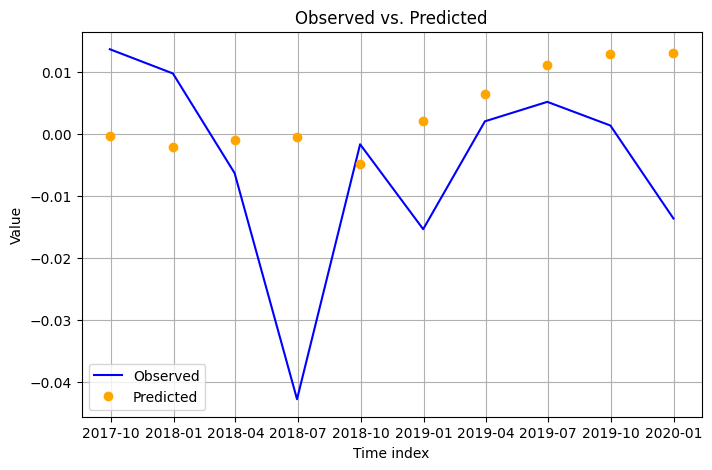

[[-0.00029714]
 [-0.00212742]
 [-0.00106262]
 [-0.00054367]
 [-0.00494755]
 [ 0.00199738]
 [ 0.00640331]
 [ 0.01115538]
 [ 0.01295627]
 [ 0.01305287]]


In [17]:
# for idx in range(raw_predictions.prediction.shape[0]):
#     best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True, show_future_observed=True)

# import matplotlib.pyplot as plt
import numpy as np

# Extract observed and predicted values
idx = 0  # Choose the index of the time series to plot
arg = hp.get_country(test, 'Argentina')
observed = actuals[idx].detach().cpu().numpy()
predicted = raw_predictions.prediction[idx].detach().cpu().numpy()


# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(arg.index.get_level_values('TIME_PERIOD'), arg['l_GDP_dif'], label="Observed", color="blue")  # Past data
plt.plot(arg.index.get_level_values('TIME_PERIOD'), predicted, 'o', label="Predicted", color="orange")  # Future data

# Formatting
plt.xlabel("Time index")
plt.ylabel("Value")
plt.title("Observed vs. Predicted")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

print(predicted)


In [63]:
def iterative_forecast(model, initial_sequence, forecast_steps, window_size=24):
    """
    Generate iterative one-step-ahead forecasts
    initial_sequence: (seq_len, n_features) initial input sequence
    forecast_steps: number of steps to forecast ahead
    window_size: size of input window to maintain
    """
    predictions = []
    buffer = initial_sequence.copy()
    
    for _ in range(forecast_steps):
        # Reshape input for model (add batch and time dimensions)
        model_input = buffer[-window_size:].reshape(1, -1, buffer.shape[-1])
        
        # Get prediction (assuming your model outputs numpy array)
        pred = model.predict(model_input, verbose=0)[0, -1]
        
        # Store prediction
        predictions.append(pred)
        
        # Update buffer with prediction (append as new time step)
        new_step = np.zeros_like(buffer[0:1])  # Maintain feature dimensions
        new_step[0, 0] = pred  # Assuming target is first column
        buffer = np.concatenate([buffer, new_step], axis=0)
    
    return np.array(predictions)

# Example usage:
# Assuming you have your time series data in X_test and trained model
window_size = 24 # Should match your model's input sequence length
forecast_steps = 10  # How far to forecast

# Get initial sequence from end of training data
initial_sequence = train[-window_size:]  

# Generate forecasts
forecasts = iterative_forecast(best_tft, initial_sequence, forecast_steps, window_size)

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [65]:
train[-window_size:] 

,,time_idx,Country_index,l_GDP_dif,hd_dif,pd_dif,l_GDP_dif_lag1,hd_dif_lag1,pd_dif_lag1
TIME_PERIOD,Country,,,,,,,,
2011-09-30,United States,13,United States,-0.000223,-0.800003,0.000000,0.006743,-1.199997,-0.200005
2011-12-31,United States,14,United States,0.011168,-0.799995,0.100006,-0.000223,-0.800003,0.000000
2012-03-31,United States,15,United States,0.008351,-1.400001,-0.300003,0.011168,-0.799995,0.100006
2012-06-30,United States,16,United States,0.004454,-1.099999,0.099998,0.008351,-1.400001,-0.300003
2012-09-30,United States,17,United States,0.001439,-0.800003,0.400002,0.004454,-1.099999,0.099998
2012-12-31,United States,18,United States,0.001156,-0.900002,0.599998,0.001439,-0.800003,0.400002
2013-03-31,United States,19,United States,0.009817,-1.000000,-0.199997,0.001156,-0.900002,0.599998
2013-06-30,United States,20,United States,0.002673,-0.500000,0.500000,0.009817,-1.000000,-0.199997
2013-09-30,United States,21,United States,0.008477,-0.400002,0.500000,0.002673,-0.500000,0.500000
